In [1]:
# Importing Libraries
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import cut_tree


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Reading and Understanding the Data:

In [2]:
# Read the data
country_data = pd.read_csv('Country-data.csv')
country_data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [3]:
# Check the dataset shape to know the number of rows and columns
country_data.shape

(167, 10)

In [4]:
# Check the data types
country_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [5]:
# Describe the dataset
country_data.describe(percentiles = [0.25,0.50, 0.75, 0.95])

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
95%,116.000000,80.570000,11.570000,81.140000,48290.000000,20.870000,81.400000,5.861000,48610.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


### Cleaning the Data:

In [6]:
# Converting exports, imports and health to actual values since they are in % of gdpp

cols = ['exports', 'imports', 'health']

for i in cols:
    country_data[i] = round((country_data[i]/100) * country_data['gdpp'],2)

# Re-check the data again
country_data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.92,248.30,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.90,1987.74,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.98,1400.44,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.60,1514.37,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.66,7185.80,19100,1.44,76.8,2.13,12200


In [7]:
#Checking for null values
country_data.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

Since there are no null-values, we can proceed with the dataset.

### Data Preparation for Clustering (EDA):

#### Univariate Analysis (Continuous)

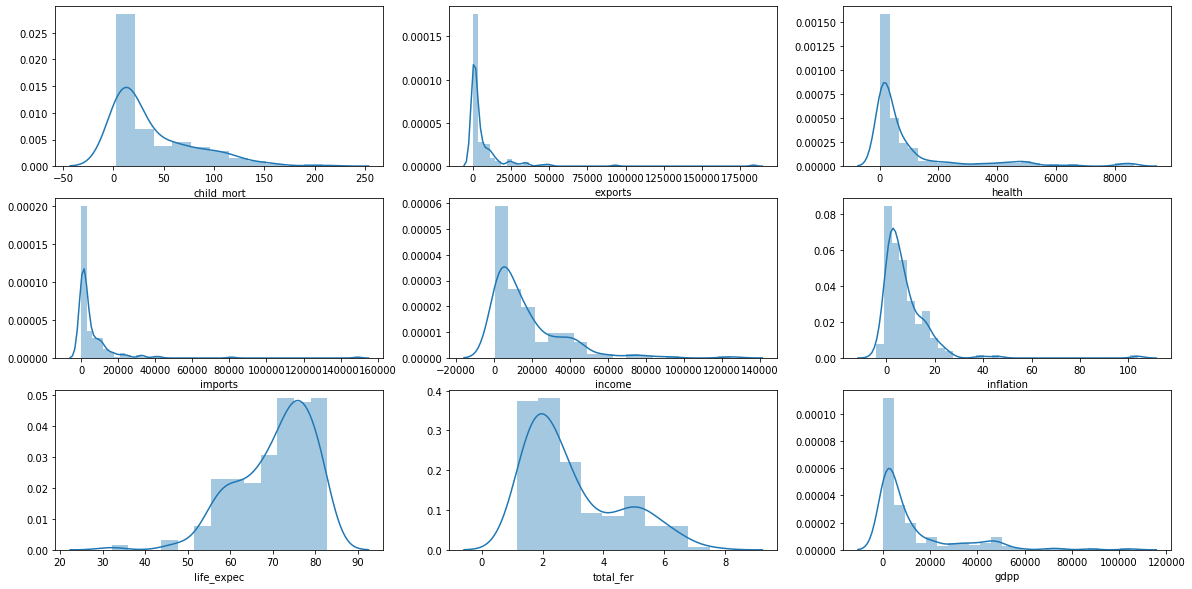

In [8]:
# Visualising the distribution of each column using distplot()
plt.figure(figsize = [20,10])
feature = country_data.columns[1:]
for i in enumerate(feature):
    plt.subplot(3,3,i[0]+1)
    sns.distplot(country_data[i[1]])
plt.show()

`Inferences:` Most of the plots are left skewed except for the variable 'life_expec' which is right skewed.

#### Bivariate Analysis (Continuious - Continuous)

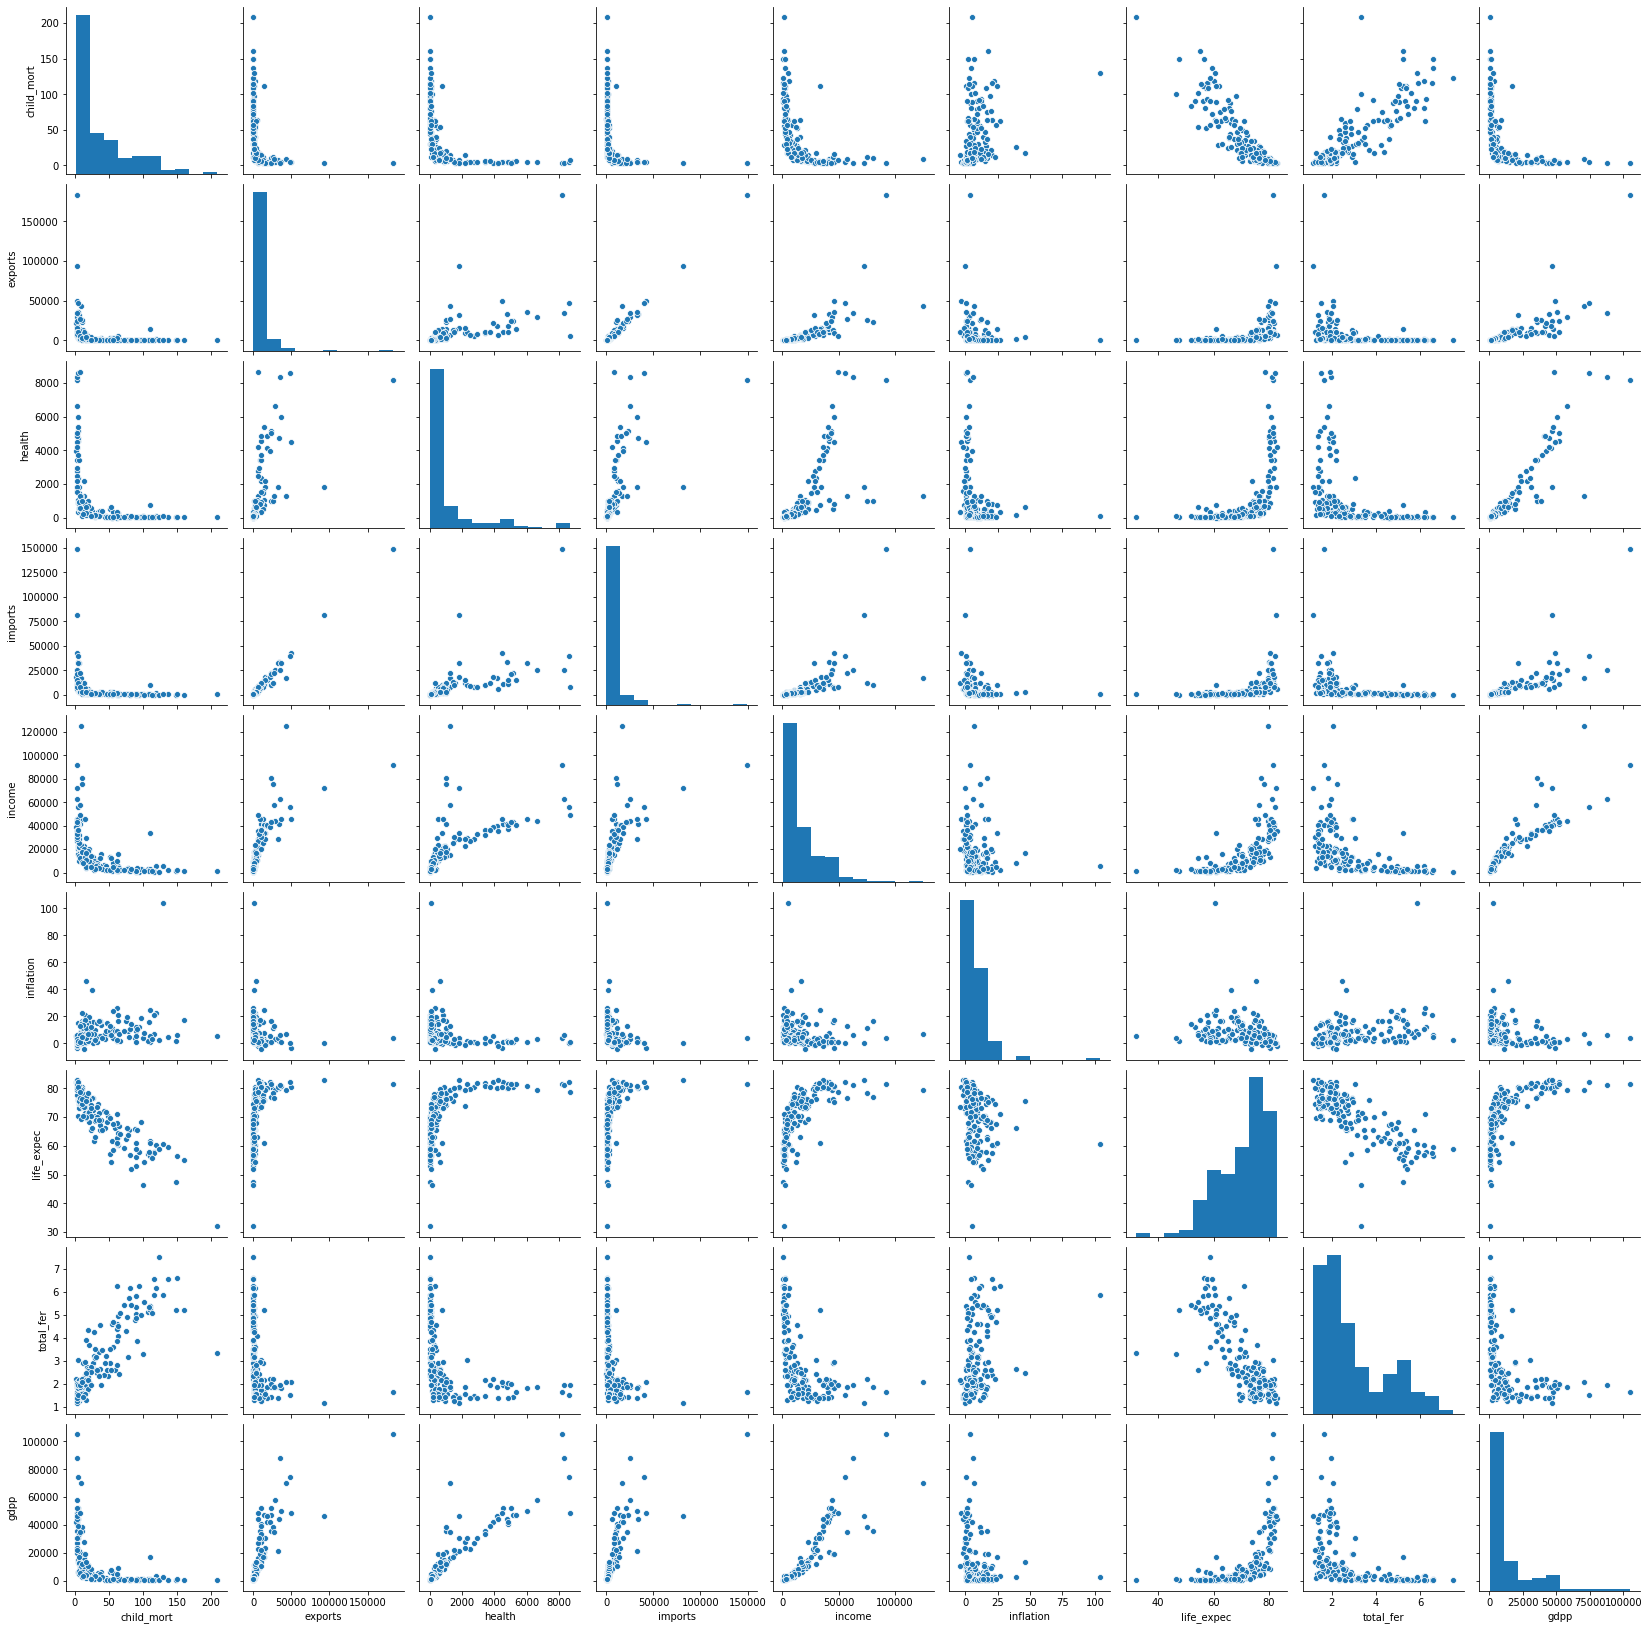

In [9]:
#Visualising all numeric data using pairplots
sns.pairplot(data = country_data)
plt.show()

`Inferences:`
It shows that some of the variables are having correlation with other variables as follows:
- child_mort & life_expec: Has -ve Correlation. As the child mortality is increasing the life expectancy of infants decreasing drastically.
- child_mort & total_fer: Has +ve Correlation. As the death of infants are increasing, the infants are born at the same rate.
- exports & imports: Has +ve Correlatation. Exports and imports are also increasing at th same rate.
- exports & income, exports & gdpp, imports & gdpp: Have slightly +ve Correlatation. As exports/imports are increasing in small amount, the income and gdpp are increasing in large amount
- health & income: Has +ve Correlation. As the net income increases so does the health expense.
- health & gdpp, income & gdpp: Have +ve Correlation: As the expenditure of health / net income of a person are increasing so does the gdpp.
- life_expec & total_fer: Has -ve Correlation. As the life expectancy of an infant is more, the infants born are less.

For remaining variables, the data points are either acuumulated at the bottom-left or top-left of the plots.

#### Outlier Treatment:

In [10]:
feature = country_data.columns[1:]
for i in enumerate(feature):
    print(i)

(0, 'child_mort')
(1, 'exports')
(2, 'health')
(3, 'imports')
(4, 'income')
(5, 'inflation')
(6, 'life_expec')
(7, 'total_fer')
(8, 'gdpp')


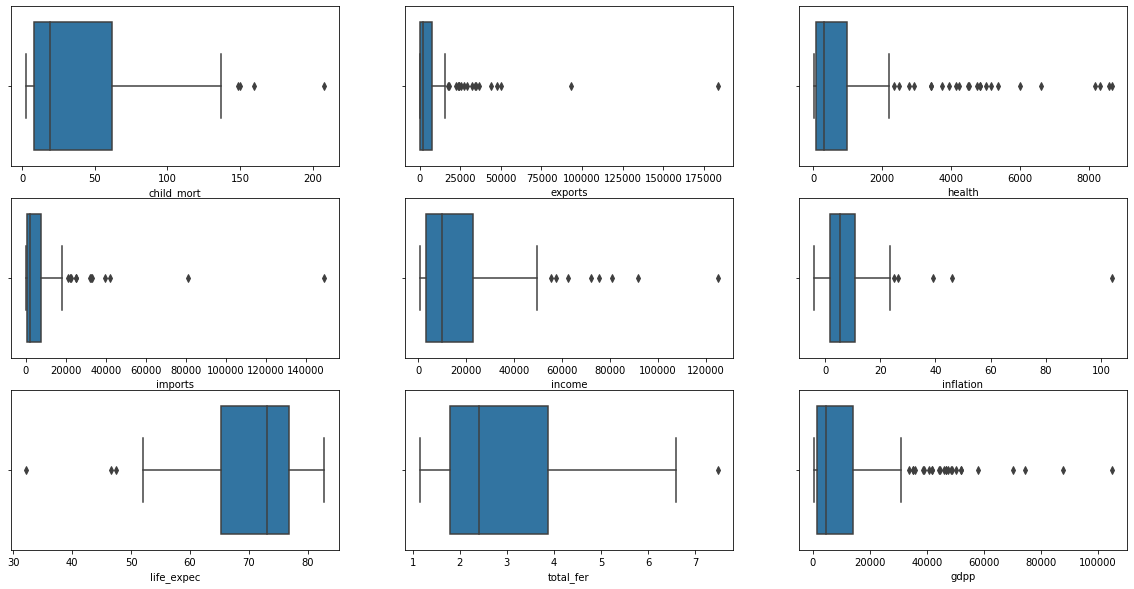

In [11]:
#Visualizing all numeric data using boxplots to check for outliers.
plt.figure(figsize = [20,10])
feature = country_data.columns[1:]
for i in enumerate(feature):
    plt.subplot(3,3,i[0]+1)
    sns.boxplot(country_data[i[1]])
plt.show()

`Inferences:`
- The plot shows that there are outliers at the higher fence except for the column 'life_expec', which is having the outlier at the lower fence. This outlier of life_expec at the lower fence will not be treated as it might be an important for analysis.
- To remove outliers at the higher fence, capping method can be used instead of deleting the outliers as it would reduce the amount of data from the dataset significantly.

To over come the outliers, they are capped as the there are less data in the data set.
- For variables 'child_mort' and 'inflation' soft-range capping will be used as a single data point is way out of range.
- For remaining variables, mid-range capping will be the better option.

In [12]:
col1 = ['child_mort', 'inflation']
col2 = ['exports', 'health', 'imports', 'income', 'life_expec', 'total_fer', 'gdpp']

# Soft-range Capping (1-99)
for i in enumerate(col1):
    lower_quan = country_data[i[1]].quantile(0.01)
    upper_quan = country_data[i[1]].quantile(0.99)
    
    country_data[i[1]][country_data[i[1]]>=upper_quan] = upper_quan
    
# Mid-range Capping (5-95)
for i in enumerate(col2):
    lower_quan = country_data[i[1]].quantile(0.05)
    upper_quan = country_data[i[1]].quantile(0.95)
    
    country_data[i[1]][country_data[i[1]]>=upper_quan] = upper_quan

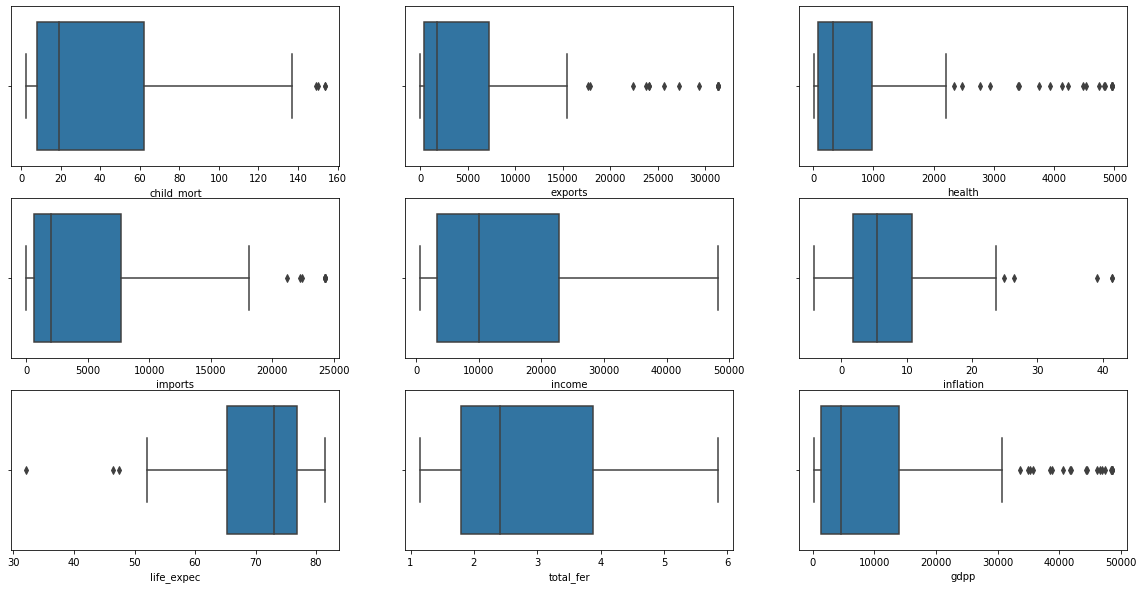

In [13]:
# Re-checking the boxplots after capping is employed
plt.figure(figsize = [20,10])
feature = country_data.columns[1:]
for i in enumerate(feature):
    plt.subplot(3,3,i[0]+1)
    sns.boxplot(country_data[i[1]])
plt.show()

`Inferences:` After employing the capping method, some of the data points which were way out of range are within range. But yet some of the data points are at the upper fence and remaining analysis will be carried without further capping of outliers.


### Hopkin's Score
To check for cluster tendency hopkin's score needs to calculated. The code is taken from External Library.

In [14]:
# Hopskin's Score Calculation
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan

def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns\n",
    n = len(X) # rows\n",
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
    
    rand_X = sample(range(0, n, 1), m)
    
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
        
        H = sum(ujd) / (sum(ujd) + sum(wjd))
        if isnan(H):
            print(ujd, wjd)
            H = 0
    return H

In [15]:
# Calling the function
hopkins(country_data.drop('country', axis=1))

0.9179951072318916

A value above 0.8 is considered as a good score and tells that the data is good for clustering process.

### Scaling of Data:
As the data are in different ranges, it is better to scale the data to a particular range so that the cluster formation is proper. Here, StandardScaler is used for scaling the data.

In [16]:
# Data Scaling and storing it in the dataframe 'country_scaled'
scaler = StandardScaler()
country_data_scaled = scaler.fit_transform(country_data.drop('country',axis =1))
country_data_scaled.shape

(167, 9)

In [17]:
# Converting to dataframe
country_data_scaled = pd.DataFrame(country_data_scaled, columns = country_data.columns[1:])
country_data_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.344006,-0.669581,-0.629433,-0.732728,-0.958349,0.265002,-1.623180,2.016421,-0.757362
1,-0.547497,-0.542172,-0.473485,-0.472182,-0.394006,-0.372075,0.654823,-0.880535,-0.523321
2,-0.272510,-0.475838,-0.530018,-0.560152,-0.192552,1.122161,0.677490,-0.019090,-0.498838
3,2.084159,-0.418960,-0.588938,-0.543087,-0.667360,1.932987,-1.181180,2.044904,-0.560376
4,-0.709406,-0.027134,-0.150685,0.306422,0.227992,-0.764618,0.711490,-0.547072,0.013312


### Modelling

#### Finding Optimal Value of 'k':
K-Means clustering algorithm requires pre-determination of number of clusters i.e., 'k'. So to find optimal value of 'k', two measures, Silhouette Score and Elbow-Curve are used.

In [18]:
#Silhouette Score
sil_score = []
for num_clusters in range(2,10):
    kmean = KMeans(n_clusters = num_clusters, max_iter = 50)
    kmean.fit(country_data_scaled)
    
    cluster_labels = kmean.labels_
    
    sil_score = silhouette_score(country_data_scaled, cluster_labels)
    print('For n_cluster s= {0}, the Silhouette Score is {1}'.format(num_clusters,sil_score))

For n_cluster s= 2, the Silhouette Score is 0.48313429181914547
For n_cluster s= 3, the Silhouette Score is 0.41854865356108933
For n_cluster s= 4, the Silhouette Score is 0.3858630842746301
For n_cluster s= 5, the Silhouette Score is 0.3538562669349953
For n_cluster s= 6, the Silhouette Score is 0.28790114103316117
For n_cluster s= 7, the Silhouette Score is 0.29525655373490195
For n_cluster s= 8, the Silhouette Score is 0.33173042584083473
For n_cluster s= 9, the Silhouette Score is 0.31735032274761454


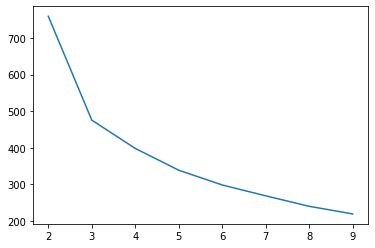

In [19]:
# elbow-curve/SSD
ssd = []
for num_clusters in range(2,10):
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(country_data_scaled)
    
    ssd.append([num_clusters, kmeans.inertia_])
    
temp = pd.DataFrame(ssd)
plt.plot(temp[0],temp[1])

    Even though the silhouette score is more for k=2, considering it won't be a good for clustering. So from both the above measures, the optimal no. of clusters is considered as 3.

### K-Means Clustering

In [20]:
# fitting model using K-Means with k =3
kmeans = KMeans(n_clusters  = 3,  random_state = 50, max_iter = 50)
kmeans.fit(country_data_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=50, tol=0.0001, verbose=0)

In [21]:
# Checking the labels
kmeans.labels_

array([2, 0, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 2, 0, 0, 0, 2,
       0, 1, 0, 2, 2, 0, 2, 1, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 1, 1,
       1, 0, 0, 0, 0, 2, 2, 0, 0, 1, 1, 2, 2, 0, 1, 2, 1, 0, 0, 2, 2, 0,
       2, 0, 1, 0, 0, 0, 2, 1, 1, 1, 0, 1, 0, 0, 2, 2, 1, 0, 2, 0, 0, 2,
       2, 0, 0, 1, 0, 2, 2, 0, 0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0,
       1, 1, 2, 2, 1, 0, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 2, 0, 0, 2, 0, 0,
       2, 1, 1, 1, 2, 2, 1, 1, 0, 0, 2, 0, 1, 1, 0, 2, 0, 2, 2, 0, 0, 0,
       0, 2, 0, 1, 1, 1, 0, 0, 0, 0, 0, 2, 2])

In [22]:
# Adding clustering labels to the dataset
country_data['cluster_id'] = kmeans.labels_
country_data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Afghanistan,90.2,55.30,41.92,248.30,1610.0,9.44,56.2,5.820,553,2
1,Albania,16.6,1145.20,267.90,1987.74,9930.0,4.49,76.3,1.650,4090,0
2,Algeria,27.3,1712.64,185.98,1400.44,12900.0,16.10,76.5,2.890,4460,0
3,Angola,119.0,2199.19,100.60,1514.37,5900.0,22.40,60.1,5.861,3530,2
4,Antigua and Barbuda,10.3,5551.00,735.66,7185.80,19100.0,1.44,76.8,2.130,12200,0


In [23]:
# Data points in each cluster
country_data.cluster_id.value_counts()

0    82
2    48
1    37
Name: cluster_id, dtype: int64

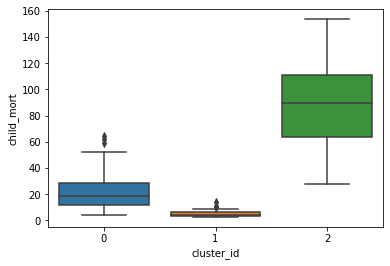

In [24]:
# Plotting the clusters with respect to the variables 'child_mort', 'income' and 'gdpp'
# 'child_mort'
sns.boxplot(data=country_data, x = 'cluster_id', y = 'child_mort')
plt.show()

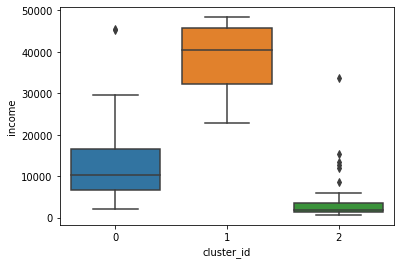

In [25]:
# 'income'
sns.boxplot(data=country_data, x = 'cluster_id', y = 'income')
plt.show()

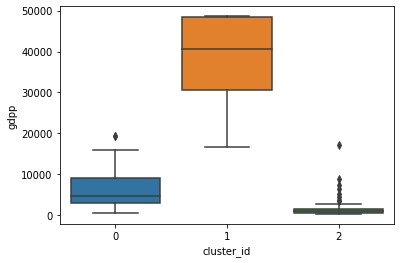

In [26]:
# 'gdpp'
sns.boxplot(data=country_data, x = 'cluster_id', y = 'gdpp')
plt.show()

`Inferences:`
From the above 3 plots following can be inferred:
- Cluster 2: Includes countries with high child mortality, low income and low gdp.
- Cluster 1: Includes countries with low child mortality, high income and high gdp.
- Cluster 0: Includes countries with child mortality slightly more than cluster 1, income and gdp slightly more than cluster 2.

#### Visualise the Clusters by Plotting Them:

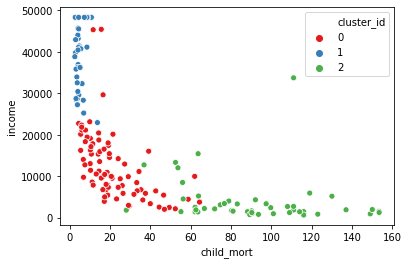

In [27]:
# 'child_mort' vs 'income'
sns.scatterplot(data = country_data, x='child_mort', y = 'income', hue = 'cluster_id', palette = 'Set1')
plt.show()

`Inference:` From the plot it can be seen that: 
- cluster 1: high 'income' but low 'child_mort', 
- cluster 2: low 'income' but high 'child_mort' and 
- cluster 0: slightly higher 'income' and lower 'child_mort' when compared to cluster 2.

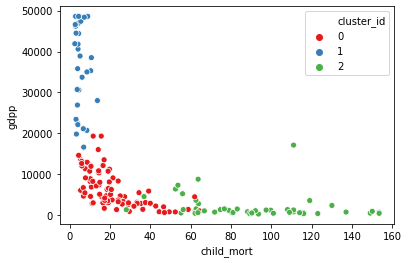

In [28]:
# 'child_mort' vs 'gdpp'
sns.scatterplot(data = country_data, x='child_mort', y = 'gdpp', hue = 'cluster_id', palette = 'Set1')
plt.show()

`Inference:` From the plot it can be seen that: 
- cluster 1: high 'gdpp' but low 'child_mort', 
- cluster 2: low 'gdpp' but high 'child_mort' and 
- cluster 0: slightly higher 'gdpp' and lower 'child_mort' when compared to cluster 2.

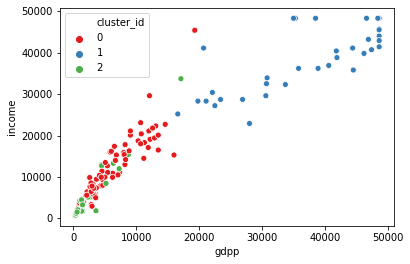

In [29]:
# 'gdpp' vs 'income'
sns.scatterplot(data = country_data, x='gdpp', y = 'income', hue = 'cluster_id', palette = 'Set1')
plt.show()

`Inference:` From the plot it can be seen that: 
- cluster 1: high 'gdpp'and 'income', 
- cluster 2: low 'gdpp'and 'income' and 
- cluster 0: slightly higher 'gdpp' and 'income' when compared to cluster 2.

### Cluster Profiling

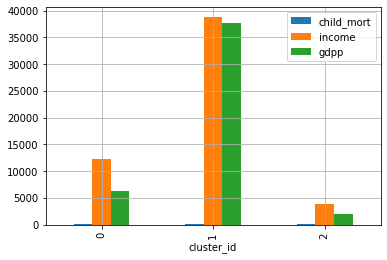

In [30]:
# Cluster Profiling with respect to the variabels ['child_mort', 'income', 'gdpp']
country_data.drop(['country', 'exports', 'imports', 'health', 'inflation', 'life_expec', 'total_fer'],axis =1).groupby('cluster_id').mean().plot(kind = 'bar', grid = True)
plt.show()

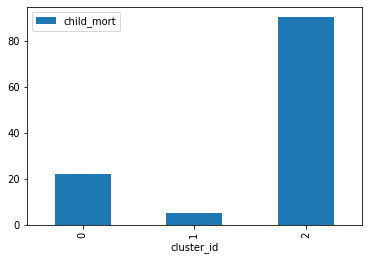

In [31]:
# To check child_mort column
country_data.drop(['country', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp'], axis =1).groupby('cluster_id').mean().plot(kind = 'bar')
plt.show()

`Inference:`  From the above two bar plots it can be clearly seen that **cluster 2** is having **low 'income' and 'gdpp'** and **high 'child_mort'** when compared to other two clusters.

In [32]:
# Top-5 countries that need immediate aid
country_data[country_data['cluster_id'] == 2].sort_values(by = ['child_mort','income','gdpp'], ascending=[False, True, True]).reset_index().head()

,index,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,132,Sierra Leone,153.4,67.03,52.27,137.66,1220.0,17.20,55.0,5.200,399,2
1,66,Haiti,153.4,101.29,45.74,428.31,1500.0,5.45,32.1,3.330,662,2
2,32,Chad,150.0,330.10,40.63,390.20,1930.0,6.39,56.5,5.861,897,2
3,31,Central African Republic,149.0,52.63,17.75,118.19,888.0,2.01,47.5,5.210,446,2
4,97,Mali,137.0,161.42,35.26,248.51,1870.0,4.37,59.5,5.861,708,2


### Hierarchical Clustering

In [33]:
country_data_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.344006,-0.669581,-0.629433,-0.732728,-0.958349,0.265002,-1.623180,2.016421,-0.757362
1,-0.547497,-0.542172,-0.473485,-0.472182,-0.394006,-0.372075,0.654823,-0.880535,-0.523321
2,-0.272510,-0.475838,-0.530018,-0.560152,-0.192552,1.122161,0.677490,-0.019090,-0.498838
3,2.084159,-0.418960,-0.588938,-0.543087,-0.667360,1.932987,-1.181180,2.044904,-0.560376
4,-0.709406,-0.027134,-0.150685,0.306422,0.227992,-0.764618,0.711490,-0.547072,0.013312


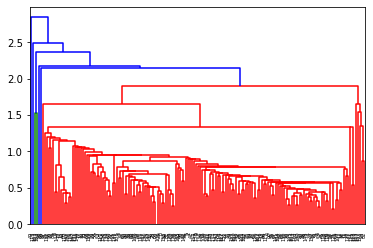

In [34]:
# Single Linkage
single_merge = linkage(country_data_scaled, method = 'single', metric = 'euclidean')
dendrogram(single_merge)
plt.show()

`Inferences:`  The single linkage doesn't construct dendrogram with proper tree fromation. So I will be checking with complete linkage.

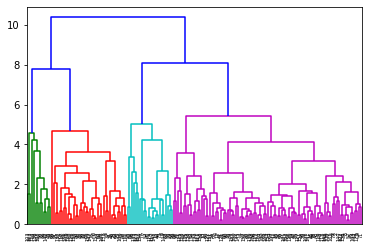

In [35]:
# Complete Linkage
complete_merge = linkage(country_data_scaled, method = 'complete', metric = 'euclidean')
dendrogram(complete_merge)
plt.show()

`Inferences:` The complete linkage does construct dendrogram with proper tree fromation and so the optimal number of clusters from dendrogram  i.e., k = 4.

In [36]:
# Cutting  the dendrogram for k=3
cluster_labels = cut_tree(complete_merge, n_clusters = 3).reshape(-1,)
cluster_labels

array([0, 1, 1, 0, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0,
       1, 2, 1, 0, 0, 1, 0, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       2, 1, 1, 1, 1, 0, 0, 1, 1, 2, 2, 0, 0, 1, 2, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 2, 1, 1, 1, 0, 2, 1, 1, 1, 2, 1, 1, 0, 0, 2, 1, 0, 1, 1, 0,
       0, 1, 1, 2, 1, 0, 0, 1, 1, 0, 2, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       2, 1, 0, 0, 2, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 2, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 2, 2, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 2, 1, 2, 1, 1, 1, 0, 1, 0, 0])

In [37]:
# Re-checking the original data set by adding the 'cluster_labels' obtained from hierarchical clustering
country_data['cluster_labels'] = cluster_labels
country_data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,cluster_labels
0,Afghanistan,90.2,55.30,41.92,248.30,1610.0,9.44,56.2,5.820,553,2,0
1,Albania,16.6,1145.20,267.90,1987.74,9930.0,4.49,76.3,1.650,4090,0,1
2,Algeria,27.3,1712.64,185.98,1400.44,12900.0,16.10,76.5,2.890,4460,0,1
3,Angola,119.0,2199.19,100.60,1514.37,5900.0,22.40,60.1,5.861,3530,2,0
4,Antigua and Barbuda,10.3,5551.00,735.66,7185.80,19100.0,1.44,76.8,2.130,12200,0,1


In [38]:
# Data Points in each clusters
country_data.cluster_labels.value_counts()

1    94
0    50
2    23
Name: cluster_labels, dtype: int64

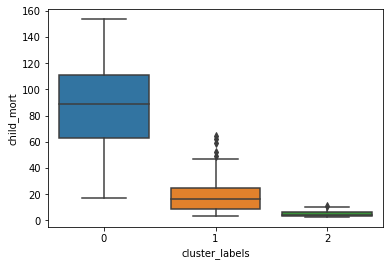

In [39]:
# Plotting the clusters with respect to the variables 'child_mort', 'income' and 'gdpp'
# 'child_mort'
sns.boxplot(data=country_data, x = 'cluster_labels', y = 'child_mort')
plt.show()

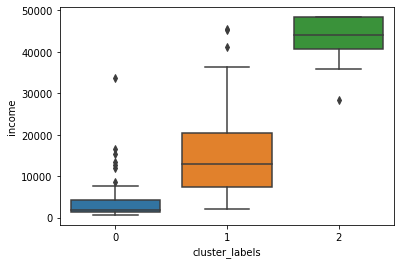

In [40]:
# 'income'
sns.boxplot(data=country_data, x = 'cluster_labels', y = 'income')
plt.show()

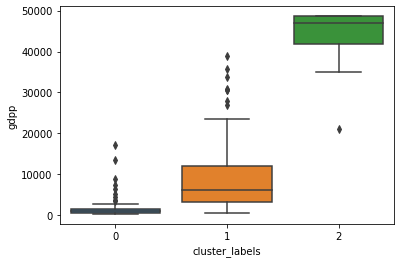

In [41]:
# 'gdpp'
sns.boxplot(data=country_data, x = 'cluster_labels', y = 'gdpp')
plt.show()

`Inferences:`
From the above 3 plots following can be inferred:
- Cluster 0: Includes countries with high child mortality, low income and low gdp.
- Cluster 2: Includes countries with low child mortality, high income and high gdp.
- Cluster 1: Includes countries with child mortality slightly more than cluster 2, income and gdp is more than cluster 0.

#### Visualise the Clusters by Plotting Them:

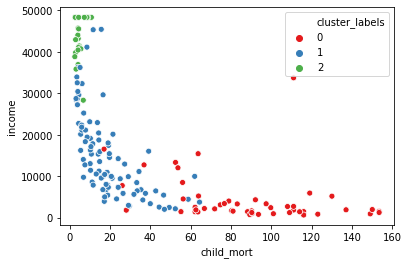

In [42]:
# 'child_mort' vs 'income'
sns.scatterplot(data = country_data, x='child_mort', y = 'income', hue = 'cluster_labels', palette = 'Set1')
plt.show()

`Inference:` From the plot it can be seen that: 
- cluster 2: high 'income' but low 'child_mort', 
- cluster 0: low 'income' but high 'child_mort' and 
- cluster 1: slightly higher 'income' and lower 'child_mort' when compared to cluster 0.

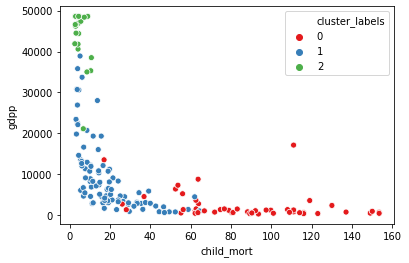

In [43]:
# 'child_mort' vs 'income'
sns.scatterplot(data = country_data, x='child_mort', y = 'gdpp', hue = 'cluster_labels', palette = 'Set1')
plt.show()

`Inference:` From the plot it can be seen that: 
- cluster 2: high 'gdpp' but low 'child_mort', 
- cluster 0: low 'gdpp' but high 'child_mort' and 
- cluster 1: slightly higher 'income' and lower 'child_mort' when compared to cluster 0.

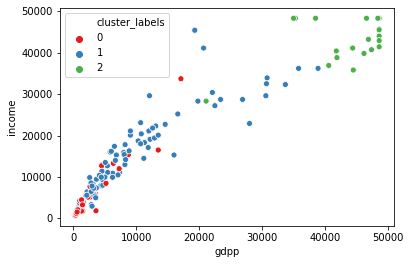

In [44]:
# 'gdpp' vs 'income'
sns.scatterplot(data = country_data, x='gdpp', y = 'income', hue = 'cluster_labels', palette = 'Set1')
plt.show()

`Inference:` From the plot it can be seen that: 
- cluster 2: high 'gdpp'and 'income', 
- cluster 0: low 'gdpp'and 'income' and 
- cluster 1: slightly higher 'gdpp' and 'income' when compared to cluster 2.

### Cluster Profiling

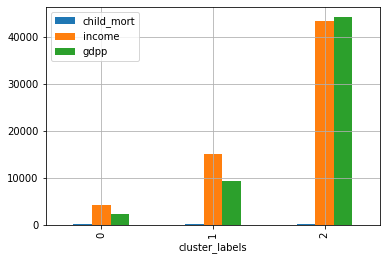

In [45]:
# Cluster Profiling with respect to the variabels ['child_mort', 'income', 'gdpp']
country_data.drop(['country','exports','health', 'imports','inflation', 'life_expec','total_fer', 'cluster_id'],axis =1).groupby('cluster_labels').mean().plot(kind = 'bar', grid = True)
plt.show()

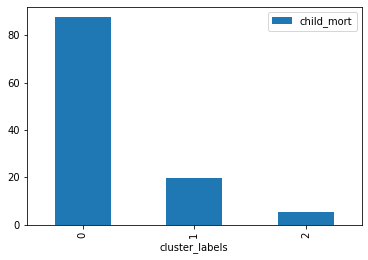

In [46]:
# To check child_mort column
country_data.drop(['country','exports','health', 'imports','income','inflation', 'life_expec','total_fer', 'gdpp', 'cluster_id'], axis =1).groupby('cluster_labels').mean().plot(kind = 'bar')
plt.show()

**`Inference:`**  From the above two bar plots it can be clearly seen that **cluster 0** is having **low 'income' and 'gdpp** and **high 'child_mort'** when compared to other two clusters.

In [47]:
# Top-5 countries that need immediate aid
country_data[country_data['cluster_labels'] == 0].sort_values(by = ['child_mort','income','gdpp'], ascending=[False, True, True]).reset_index().head()

,index,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,cluster_labels
0,132,Sierra Leone,153.4,67.03,52.27,137.66,1220.0,17.20,55.0,5.200,399,2,0
1,66,Haiti,153.4,101.29,45.74,428.31,1500.0,5.45,32.1,3.330,662,2,0
2,32,Chad,150.0,330.10,40.63,390.20,1930.0,6.39,56.5,5.861,897,2,0
3,31,Central African Republic,149.0,52.63,17.75,118.19,888.0,2.01,47.5,5.210,446,2,0
4,97,Mali,137.0,161.42,35.26,248.51,1870.0,4.37,59.5,5.861,708,2,0


#### `Final Conclusion:`
- The 3 clusters formed in both cases are:
  1. C1 - High Child Mortality, Low Income & GDPP.
  2. C2 - Low Child Mortality, High Income & GDPP.
  3. C3 - Better cluster when compared to C1.
- The segmentation of data was better in K-Means when compared to  Hierarchical for number of clusters = 3.
- Both K-Means and Hierarchical Clustering Algorithms are producing the same results for number of clusters = 3. Hence, the top-5 countries which need immediate aid are as follows:
  1. Sierra Leone
  2. Haiti
  3. Chad
  4. Central African Republic
  5. Mali